# Is Bitcoin a good investment? 

   
### Introduction

The CFO of an investment fund wants to explore if it is a good idea to invest some of the fund's assets in Bitcoin. The purpose of this project is to understand the return profile of Bitcoin as an investment and compare it to the common investment instruments.

### Objectives

Using daily and monthly price data for Bitcoin (BTC), S&P 500 index and Gold this report will:

* compare historical monthly returns for all three assets from 2014 to 2021 to show that while BTC is a worthy investment, it is not a perfect hedge against inflation
* for BTC, in particular, anticipate price volatility around halving dates and model volatility profile using risk models
* develop scenarios for portfolios with minimum volatility (0% weighting to BTC) and maximum return (0% < weighting to BTC) using modern portfolio theory (MPT)
* explain the Mayer Multiple and examine it's use to determine the price trend of Bitcoin

### Datasets
    
The following datasets were used in the analysis: 
    
<b>S&P 500:</b> The Standard & Poors (S&P) 500 is an index containing 500 of the largest companies trading on the NYSE and NASDAQ. These equities are weighted by their market capitalization.  The index is one of the most popular indices generally used to understand the health of the stock market. 

<b>Gold</b>: remains a popular vehicle for investors seeking a stable investment, given that it retains value over long periods of time.  

<b>Bitcoin</b>: is a decentralized digital currency that utilizes a peer-to-peer network without the need for intermediaries. (It is a free, open source, permissionless decentralized internet native monetary protocol). Decentralized currencies are not owned by a particular country, not confined by geographic boundaries, not issued by financial institutions.  Between 2014 and 2021, BTC/USD prices increased 100x, driving it's popularity as an investment asset class.

<b>Inflation</b>: The Consumer Price Index (CPI for all Urban Consumers) is used to derive inflation, whereby CPI-U is the average change in prices paid by urban consumers for a market basket of consumer goods or services.
   

In [18]:
#Import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.optimize as sco
from scipy import stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%matplotlib inline

### Preparing the Data

* The daily data for Bitcoin (BTC), S&P 500, Gold and Inflation is imported into dataframes.  
* In order to make the data easier to analyze, the data is averaged by month, using the <b>resample.mean()</b> function.    Bitcoin and S&P 500 data are resampled for the start of the month <b>(MS)</b>, while Gold and Inflation (CPI-U) data are already organized monthly.  
* Trading days for S&P 500 and Gold are Monday - Friday, while Bitcoin trades all days of the week. For any <b>NaN</b> values from misaligned trading days, the dataframe forward fills prior period numbers to ensure downstream analysis is not impacted. 
* The returns are converted to <b>log</b> returns to normalize the time series for unevenly priced assets. 

In [19]:
# Read csv input files for BTC, Gold, S&P 500 and CPI data: 2014 to 2021 
# Convert default "Date" column from string to date format using parse_dates and assign date to index_col  

bitcoin = pd.read_csv('./data/bitcoin-usd.csv',parse_dates=['date'], index_col='date', dtype=np.float64)
sp500 = pd.read_csv('./data/sp500.csv',parse_dates = ["date"], index_col = "date", dtype=np.float64)
monthly_data = pd.read_csv('./data/monthly_data.csv',parse_dates = ["date"], index_col = "date", dtype=np.float64)

bitcoin.fillna(method='ffill', inplace=True)
sp500.fillna(method='ffill', inplace=True)
monthly_data.fillna(method='ffill', inplace=True)

# Resample bitcoin and S&P daily data into monthly averages
bitcoin_mth = bitcoin.resample('MS').mean()
sp500_mth= sp500.resample('MS').mean()

# Create an Empty DataFrame for monthly returns
mth_return = pd.DataFrame(columns = ['BTC_%chg','G_%chg','S&P_%chg','inf%'], dtype=np.float64)

# Add monthly % change from daily close prices 
mth_return['BTC_%chg']= np.log(bitcoin_mth['close']/bitcoin_mth['close'].iloc[1]).bfill()
mth_return['G_%chg']= np.log(monthly_data['gold_usd']/monthly_data['gold_usd'].iloc[1]).bfill()
mth_return['S&P_%chg']= np.log(sp500_mth['close']/sp500_mth['close'].iloc[1]).bfill()
mth_return['inf%']= np.log(monthly_data['cpi_us']/monthly_data['cpi_us'].iloc[1]).bfill()

# Fill NaN with zeroes
mth_return.fillna(0, inplace=True)  

# Write the monthly data to a new dataframe to be for portfolio optimization
BTCclose = bitcoin_mth['close']
Sandpclose = sp500_mth['close']
goldclose= monthly_data['gold_usd']
dfAll = pd.DataFrame({'BTC':BTCclose, 'S&P':Sandpclose, 'Gold':goldclose}, index=bitcoin_mth.index)
dfAll.fillna(0, inplace=True)

### Investment performance

To answer the question on investment performance between the different asset classes, consider returns over time with rise of inflation.

<b>Impact of inflation</b>:
* The inflation here is plotted as an increase in the basket of prices to improve readability.
* Note the difference in the scale of the two y-axes on these charts, the exponential price movement of bitcoin makes a linear comparison difficult, however, the charts are presented to show the overall trend in monthly asset returns.  
    
<b>Impact of the COVID-19 pandemic on investment performance</b>:   
* Staying with this high-level view, the advent of the COVID-19 pandemic impacted performance of all three assets differently.  
* The sell-off experienced in the equities market in March 2020 did not translate into bitcoin or gold. 
* Gold prices benefited as a default safe haven investment through second and third quarter of 2020, meanwhile BTC benefited from improved consumer sentiment (among retail investors) around digital assets as an alternative safe haven asset which continues to drive it's exponential growth into 2021. 

<b>Bitcoin trends</b>:    
* The shaded purple areas in the first and last chart indicate Bitcoin halving dates, July 2016 and May 2020.  
* In total, there will eventually be 21 million Bitcoin in circulation, of which approximately 18+ million coins have been mined.  
* Bitcoin halving decreases the number of new Bitcoins that are generated, leading to a decrease in the total supply of new coins. By the rule of supply/demand economics, lower the supply, higher the price. In analyzing Bitcoin trends, previous halving dates have been succeeded by significant price increases.  Some of this behavior is evident in the 90-day period following the halving. 
   
To summarize, Bitcoin is a good alternative safe haven asset and since there is a fixed supply of coins it tends to be a better, although not perfect, hedge against inflation compared to equities and many other digital assets.  

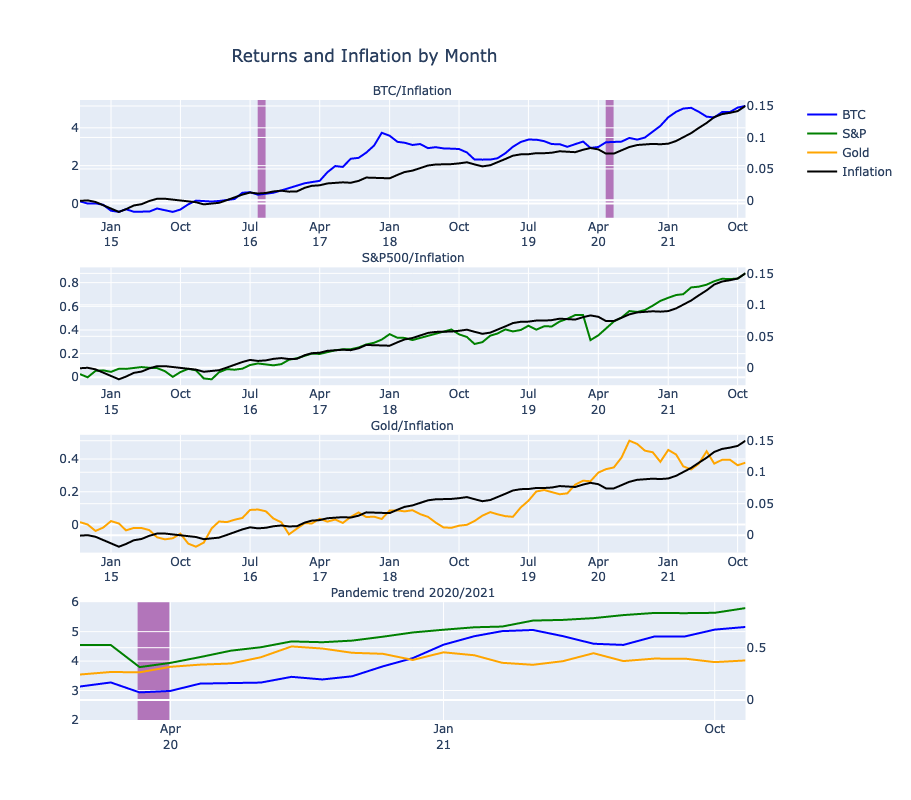

In [20]:
# Plot chart with three series BTC, S&P and Gold depicting returns and inflation
fig = make_subplots(rows=4, cols=1,
                    specs=[[{'secondary_y': True}], 
                           [{'secondary_y': True}],
                           [{'secondary_y': True}], 
                           [{'secondary_y': True}]],
                    subplot_titles=('BTC/Inflation','S&P500/Inflation', 'Gold/Inflation', 'Pandemic trend 2020/2021'),
                    vertical_spacing=0.08, horizontal_spacing =0.1)        
# Top left
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['BTC_%chg'], name='BTC', line=dict(color='blue')),
    row=1, col=1, secondary_y=False)
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['inf%'], name='Inf%',line=dict(color='black'), showlegend=False),
    row=1, col=1,secondary_y=True)

# Top right
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['S&P_%chg'], name="S&P", line=dict(color='green')),
    row=2, col=1, secondary_y=False)
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['inf%'], name='Inf', line=dict(color='black'),showlegend=False),
    row=2, col=1, secondary_y=True)

# Bottom left
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['G_%chg'], name="Gold", line=dict(color='orange')),
    row=3, col=1, secondary_y=False)
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['inf%'], name="Inflation", line=dict(color='black')),
    row=3, col=1, secondary_y=True)

# Bottom right
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['BTC_%chg'], name="BTC", line=dict(color='blue'),showlegend=False),
    row=4, col=1, secondary_y=False)
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['S&P_%chg'], name="S&P", line=dict(color='green'),showlegend=False),
    row=4, col=1, secondary_y=True)
fig.add_trace(
    go.Scatter(x=mth_return.index, y=mth_return['G_%chg'], name="Gold", line=dict(color='orange'),showlegend=False),
    row=4, col=1, secondary_y=True)

# Update layout of the charts
fig.update_annotations(font_size=12, yanchor='bottom')         
fig.update_layout(autosize=False, height=800, width=800,
                title={
                    'text': "Returns and Inflation by Month",
                    'x':0.4,
                    'xanchor': 'center',                      
                    'yanchor': 'top'})                        

# Update axes 
fig.update_xaxes(dtick="M9", tickformat='%b\n%y')             
fig.update_yaxes(autorange=False, range=[2,6],secondary_y=False, row=4, col=1)
fig.update_xaxes(autorange=False, range=['2020-01-01','2021-11-01'], row=4, col=1)

# Add shaded spaces to the charts to indicate BTC halving dates, 07/2016 and 05/2020
fig.add_vrect(
    x0="2016-07-31", x1="2016-08-31",
    fillcolor="Purple", opacity=0.5,
    layer="below", line_width=0, row=1, col=1)

fig.add_vrect(
    x0="2020-04-30", x1="2020-05-31",
    fillcolor="Purple", opacity=0.5,
    layer="below", line_width=0, row=1, col=1)

# Add shaded space to the last chart to indicate start of the COVID-19 pandemic, 03/2020
fig.add_vrect(
    x0="2020-02-28", x1="2020-03-31",
    fillcolor="Purple", opacity=0.5,
    layer="below", line_width=0, row=4, col=1)



### Portfolio Optimization
    
* Using a combination of metrics, we can evaluate if Bitcoin should be included in the fund. The Mean-Variance Optimization (Diversification) methodology relies on historical returns, volatility/variance, and a covariance/correlation matrix to draw its conclusion.  

* <b>Covariance and correlation</b>: Covariance measures the direction in which two variables move together, while correlation measures the strength of the relationship between variables.   So a negative covariance indicates that two variables move away from each other, and a negative correlation shows a relationship if A increases then B will decrease by a specific %.   Covariance and correlation can be represented formulaically:-
    
                            Cov[X,Y] = Corr[X,Y] . std(X) . std(Y)
    
* <b>Correlation</b>: Negative correlation, although not strong at -0.10 for Gold and BTC indicates an inverse relationship (as Gold increases in price, BTC declines).  BTC remains correlated with S&P 500 (0.37), among the highest in recent times
    
         
        BTC/S&P    0.379985 
        S&P/Gold   0.03234             
        BTC/Gold  -0.104510   
    

In [21]:
# Use Log Returns
rets = dfAll.pct_change().apply(lambda x: np.log(1+x)).mean()

# Covariance
cov =  np.log(dfAll).cov()
cov_matrix = dfAll.pct_change().apply(lambda x: np.log(1+x)).cov()
print('Covariance Matrix:','\r\n',cov_matrix) 

# Correlation Matrix
cor = np.log(dfAll).corr()
cor_matrix = dfAll.pct_change().apply(lambda x: np.log(1+x)).corr()
print('Correlation Matrix:','\r\n',cor_matrix) 

Covariance Matrix: 
            BTC       S&P      Gold
BTC   0.037212  0.002617 -0.000723
S&P   0.002617  0.001274  0.000041
Gold -0.000723  0.000041  0.001287
Correlation Matrix: 
            BTC       S&P     Gold
BTC   1.000000  0.379985 -0.10451
S&P   0.379985  1.000000  0.03234
Gold -0.104510  0.032340  1.00000


### Setting up simulation

Define the portfolio return and portfolio volatility functions.  Simulate portfolio using a random number generator  and assign these weights to portfolio arrays.  The array denotes the universe of portfolios, of which several combinations of efficient portfolio (risk/return combinations) can be derived. 

* <b>Risk-free rate</b>: the model uses a default of 2% as the risk-free rate, this is overridden as the 10-year T-bill rate is 1.53% 

* <b>Functions</b>: two functions for returns and volatility are definted using average returns and average volatility.  The simulation is setup to iterate 5000 random portfolios. 

<b>Portfolios</b>: the portfolios simulated are <b>minimum volatility portfolios</b> and <max Sharpe portfolios>.  The model here doesn't accommodate shorting of stocks so the weighting limits are between 0 and 1.  For the three asset returns, randomized weights are used to create 5000 portfolios, from which the max and min return and volatility metrics are obtained.   

In [22]:
assets = 3

def portfolio_returns(w):
    return (np.sum(np.log(dfAll).pct_change().mean() * w)) * 250

def portfolio_vol(w):
    return np.sqrt(np.transpose(w) @ (np.log(dfAll).pct_change().cov() * 250) @ w)

# empty lists
listreturns = []
listvol = []

# Simulate 5000 portfolios 
for p in range(5000):   
  w = np.random.random(size = assets) 
  w /= np.sum(w) 
  listreturns.append(portfolio_returns(w))
  listvol.append(portfolio_vol(w))   
  port_returns = np.array(object = listreturns)
  port_sd = np.array(object = listvol)

print('Max expected return:',round(max(port_returns), 4))
print('Max volatility:', round(max(port_sd), 4))
print('Min volatility:', round(min(port_sd), 4))


Max expected return: 1.7508
Max volatility: 0.3547
Min volatility: 0.0532



#### Maximum Sharpe Ratio Portfolio
    
Sharpe Ratio is the slope of the optimal portfolio, where the return of the portfolio is highest and the standard deviation is lowest. 

          Sharpe Ratio = [Portfolio Return - Risk-free rate] / Standard Deviation of Portfolio

    
   In order to achieve the best risk/return combination:

            BTC      13.7%
            S&P500   48.8%
            Gold     37.5%
            
    Expected annual return: 46.1%
    Annual volatility: 7.52%
    Sharpe Ratio: 5.919

In [23]:
risk_free = 0.0153

def sharpe(w):
  return - (portfolio_returns(w) / portfolio_vol(w))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple(
  (0, 1) for w in w
)
equal_w = np.array(
  [1 / assets] * assets)

max_sharpe_results = sco.minimize(
  fun = sharpe, 
  x0 = equal_w, 
  method = 'SLSQP',
  bounds = bounds, 
  constraints = constraints
)
max_sharpe_port_return = portfolio_returns(max_sharpe_results["x"])
max_sharpe_port_vol = portfolio_vol(max_sharpe_results["x"])
max_sharpe_port_sharpe = (max_sharpe_port_return-risk_free) / max_sharpe_port_vol

print('Max Sharpe Portfolio Return:', max_sharpe_port_return)
print('Max Sharpe Portfolio Volatility:', max_sharpe_port_vol)
print('Max Sharpe Portfolio Sharpe Ratio:', max_sharpe_port_sharpe)
print('Portfolio weights: BTC, S&P500, Gold', max_sharpe_results['x'])


Max Sharpe Portfolio Return: 0.4609298856474506
Max Sharpe Portfolio Volatility: 0.07528488092237469
Max Sharpe Portfolio Sharpe Ratio: 5.9192480639895555
Portfolio weights: BTC, S&P500, Gold [0.13710145 0.48788673 0.37501182]


#### Minimum Volatility Portfolio

A traditional minimum volatility portfolio understandably omits investing in an asset like Bitcoin to avoid frequent volatility fluctuations.  The model also doesn't allow shorting of assets (indicated by weight bounds of 0 and 1).  Given these metrics, the following allocations is appropriate (yearly volatility for S&P 500 and Gold are routinely lower than Bitcoin):

            BTC      0%
            S&P500   55%
            Gold     45%


    Expected annual return: 23.75%
    Annual volatility: 5.31%
    Sharpe Ratio: 4.47

However, the limitations of modern portfolio theory are obvious.  Despite using an EMA methodology to compute returns and volatility, the most recent 24-month period was the most significant bull-run in Bitcoin returns. In order to account for this, the use of the <b>Mayer Multiple</b> is reviewed next. 

In [24]:
min_vol_results = sco.minimize(
  fun = portfolio_vol, 
  x0 = equal_w, 
  method = 'SLSQP',
  bounds = bounds, 
  constraints = constraints
)

min_vol_port_return = portfolio_returns(min_vol_results["x"])
min_vol_port_sd = portfolio_vol(min_vol_results["x"])
min_vol_port_sharpe = min_vol_port_return / min_vol_port_sd

print('Min Vol Portfolio Return:', min_vol_port_return)
print('Min Vol Portfolio Volatility:', min_vol_port_sd)
print('Min Vol Portfolio Sharpe Ratio:', min_vol_port_sharpe)
print('Portfolio weights: BTC, S&P500, Gold', min_vol_results['x'])

Min Vol Portfolio Return: 0.2375682112033153
Min Vol Portfolio Volatility: 0.053141686956366854
Min Vol Portfolio Sharpe Ratio: 4.470468003742069
Portfolio weights: BTC, S&P500, Gold [0.         0.54751557 0.45248443]


### What is the Mayer Multiple? 

The metric is named for it's creator, Trace Mayer, Bitcoin enthusiast and investor.
    
    MM = Current market price / 200 day moving average(MA)   
    
The formula attempts to highlight bubbles in the Bitcoin market as it calculates the gap between today's price and 200 day MA. The two thresholds of <b>1.0 and 2.4</b>, as noted in the chart below.  A multiple of 1.0x indicates the price is equal to the 200-day MA, while 2.4x has traditionally indicated an overpriced market. In the last quarter of 2021, the MM has hovered around 1.0x with it most recently rising above 1.0.  

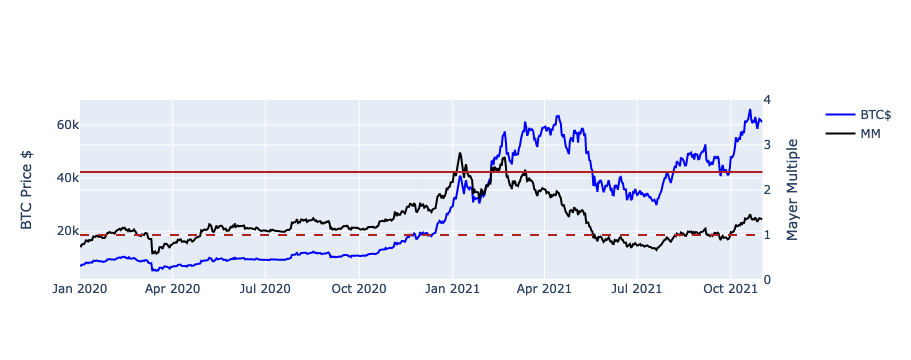

In [25]:
%matplotlib inline

# Write the data to a new dataframe 
bitcoin['MA200'] = bitcoin['close'].rolling(window = 200).mean()
bitcoin['btcMM'] = bitcoin['close']/bitcoin['MA200']

start_date = '2020-01-01'
end_date = '2021-11-01'
after_start_date = bitcoin.index >= start_date
before_end_date = bitcoin.index <= end_date
between_two_dates = after_start_date & before_end_date
btc = bitcoin.loc[between_two_dates]

fig = make_subplots(specs=[[{"secondary_y": True}]],
                    vertical_spacing=0.1, 
                    horizontal_spacing =0.1)
fig.add_trace(
    go.Scatter(x=btc.index, y=btc['close'], name='BTC$',
                line=dict(color='blue')),secondary_y=False)
fig.add_trace(
    go.Scatter(x=btc.index, y=btc['btcMM'], name='MM',line=dict(color='black')),secondary_y=True)

fig.update_xaxes(autorange=False, range=['2020-01-01','2021-11-01'])
fig.update_yaxes(autorange=False, title_text='Mayer Multiple',range=[0,4], secondary_y=True)
fig.update_yaxes(autorange=True, title_text='BTC Price $',secondary_y=False)


fig.add_hline(y=1.0, line_width=2, line_dash="dash", line_color="Firebrick", secondary_y=True)
fig.add_hline(y=2.4, line_width=2, line_color="Firebrick", secondary_y=True)


### Conclusion
    
Gold continues to serve as a strong inflationary hedge, although Bitcoin is a good store of value for long-term investment. Given the market prices are driven by large financial intermediaries and Gold isn't strongly correlated to other two assets will continue to make this an attractive investment.  
    
While the last two years have yielded volatile returns for all three assets, Bitcoin has experienced the most severe of these shocks.  According to <u>Decrypt.co</u>, Bitcoin went from being negatively correlated with the S&P in 2019 to reaching the highest correlation coefficient in 2020.  
    
While keeping in mind that Bitcoin is a deflationary asset prone to large fluctuations and it doesn't prescibe to traditional valuation models, the overall approach is that the fund should invest in Bitcoin.  
    
For a minimum volatility portfolio, 0% allocation to Bitcoin is recommended.
    
This portfolio yields 23.75% annually: 
    
    BTC         S&P500       Gold
     0%           55%         45%

Expected annual return: 23.75%
Annual volatility: 10.1%
Sharpe Ratio: 1.47
    
However, the portfolio simulation above shows us that inclusion of Bitcoin has improved the overall performance on a risk-adjusted basis (as annual return, volatility and the Sharpe Ratio have improved).  While no one metric can answer if an investor should invest in Bitcoin, the portfolio optimization model and the trend of the Mayer Multiple indicates that Bitcoin is not in an overbought market, so the investment fund should include it in their asset allocation. 

